This is the final and most important lesson. Aside from being analogous to what I would want to achieve, it's also a set by step guide as to how to apply this type of neural network learning to an actual physical phenomenon. 

### Lesson 3
#### The Duffling Oscilator and Parameter Estimation

The first steps are either not relevent to the lesson or were already discussed in the previous two lessons. As such there will be a lot of preamble code provided with no explanation. Either look through the previous 2 lessons or read through the comments of the code provided below:

In [1]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import jax
import jax.random
import numpy as np 

import optax

from functools import partial

import tqdm

In [2]:
def NN_init_params(key, num_neurons_layers):
    """
    Given a jax random key and a list of the neuron numbers
    in the layers of a network (simple fully connected network,
    i.e. 'multi-layer perceptron'), return a dictionary
    with the weights initialized randomly and biases set to zero.
    
    Returns: params, with params['weights'] a list of matrices and
    params['biases'] a list of vectors.
    """
    params = {}
    params['weights'] = []
    params['biases'] = []
    
    for lower_layer, higher_layer in zip( num_neurons_layers[:-1], num_neurons_layers[1:] ):
        key,subkey = jax.random.split( key )
        params['weights'].append( jax.random.normal( subkey,
                                        [higher_layer,lower_layer] ) /  
                                 jnp.sqrt( lower_layer ) )
        
    for num_neurons in num_neurons_layers[1:]:
        params['biases'].append( jnp.zeros( num_neurons) )
    
    return params

In [3]:
def runge_kutta_step_with_params(X,params,t,rhs,dt):
    """
    One step of the standard Runge-Kutta fourth order.
    This assumes rhs can be called like rhs(X,params,t)
    """
    k1=rhs(X,params,t)
    k2=rhs(X+0.5*dt*k1,params,t+0.5*dt)
    k3=rhs(X+0.5*dt*k2,params,t+0.5*dt)
    k4=rhs(X+dt*k3,params,t+dt)
    return( (dt/6.)*(k1+2*k2+2*k3+k4) )

# we need this partial statement to tell jax
# that the 'rhs' argument is not an array but something
# else!
@partial(jax.jit,static_argnames=['rhs'])
def runge_kutta_solve(X0,rhs,ts,params):
    """
    Solve the differential equation dX/dt=rhs(X,params,t), for all (equally spaced) times in ts,
    with initial value X(t=0)=X0.
    
    Here X0 can have ANY shape as an array, and rhs(X,params,t) must return the same shape.
    
    This is convenient in case you want to, say, do many trajectories in parallel,
    or reserve one index for the particle number, etc. You do not need to assume
    X to be a 1d array, as you would have to do for some other Runge-Kutta implementations.
    It is also nice to split the positions and velocities, e.g. X[0,:] for the positions
    of all particles, and X[1,:] for the velocities.
    
    Returns: Xs,ts
    
    where the shape of the solution Xs is the same as that of X, except we add another dimension
    at the end, of size 'nsteps'. 'ts' just is a 1d array denoting the time steps for
    the solution.
    
    Plotting the solution may work like this, if X was a 1d array:
    
    plt.plot(ts,Xs[5]) # Note that Xs[5] is the same as Xs[5,:]
    
    ...or like this, if e.g. X[1,:] were all the velocities of all particles:
    
    plt.plot(ts,Xs[1,3]) # plotting velocity of particle number 3: Xs[1,3] is the same as Xs[1,3,:]
    
    (code by Florian Marquardt 2020, 2024)
    """
    dt=ts[1]-ts[0]

    def loop_body(x,t):
        x+=runge_kutta_step_with_params(x,params,t,rhs,dt)
        return x,x
    
    _,Xs=jax.lax.scan(loop_body,X0,xs=ts)
    return Xs,ts

# batched parameters:
parallel_param_runge_kutta_solve = vmap(runge_kutta_solve,in_axes=[None,None,None,0],
                                                   out_axes=0)

# batched initial conditions:
parallel_runge_kutta_solve = vmap(runge_kutta_solve,in_axes=[0,None,None,None],
                                                   out_axes=0)

Alright the core of what we want begins now. In essence we want to apply the core basics of using neural networks to fit and optimize to a particular equation called the Duffing Oscilator. Most generally speaking, the Duffing Oscilator can be defined using the following equation:

\begin{equation}
\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = \gamma cos(\omega x)
\tag{1}
\end{equation}

Here *x* is the state, $\delta$ is the normalized damping constant, $\alpha$ is the normalized stifness constant, $\beta$ is the normalized non-linearity strength and $\gamma$ is the normalized forcing strength and $\omega$ is the frequency of forcing (everything here is mass normalized)
In this code, the equational form used is:

\begin{equation}
\dot{z} = -i(\omega_0 - \omega)z - \frac{\gamma}{2}z - i \epsilon |z|^2 z + i f
\tag{2}
\end{equation}

In this writing, $\omega_0$ is the natural frequency, $\omega$ is the driving frequency, $\gamma$ is the damping rate, $\epsilon$ is the non-linearty strength, and *f* is the strength of the oscilatory forcing. 


So we use the duffing_rhs function that we define in accordance to equation 2 to plug into the runge_kutta_solve function we define above to numerically get a result to the Duffing Oscilator dynamics using the solve_duffing function. Afterwards, just like lesson 2, we take this function that we want to generalize, and allow it to take in batch inputs for the parameters $\gamma$, $\omega$, and $\epsilon$ in the function solve_duffing_parameter_batch function; and allow it to take batch inputs for the parameter *f* in the solve_duffing_force_batch function

In [4]:
def duffing_rhs(z,rhs_params,t):
    # params = [omega_start, domega_dt , gamma, epsilon, force, omega0]
    return ( (-1j*(rhs_params[5]-(rhs_params[0]+rhs_params[1]*t)) - 0.5*rhs_params[2])*z 
            -1j*rhs_params[3]*jnp.abs(z)**2 * z + 1j*rhs_params[4] )

def solve_duffing(z0, omega0, gamma, epsilon, force, omega_start, omega_stop, t_end, nsteps):
    ts=jnp.linspace(0.,t_end, nsteps)
    domega_dt = (omega_stop - omega_start)/t_end 
    rhs_params=jnp.array([omega_start, domega_dt , gamma, epsilon, force, omega0])
    omegas=omega_start + domega_dt * ts
    return *runge_kutta_solve(z0, duffing_rhs, ts, rhs_params),omegas

# batch-processing version, where omega0,gamma,epsilon can vary across
# the samples of the batch:
solve_duffing_parameter_batch = vmap(solve_duffing,
                                    in_axes=[None,0,0,0,None,None,None,None,None])

# batch-processing version, which can be used to compute a force sweep:
solve_duffing_force_batch = vmap(solve_duffing,
                                 in_axes=[None,None,None,None,0,None,None,None,None],
                                out_axes=0)

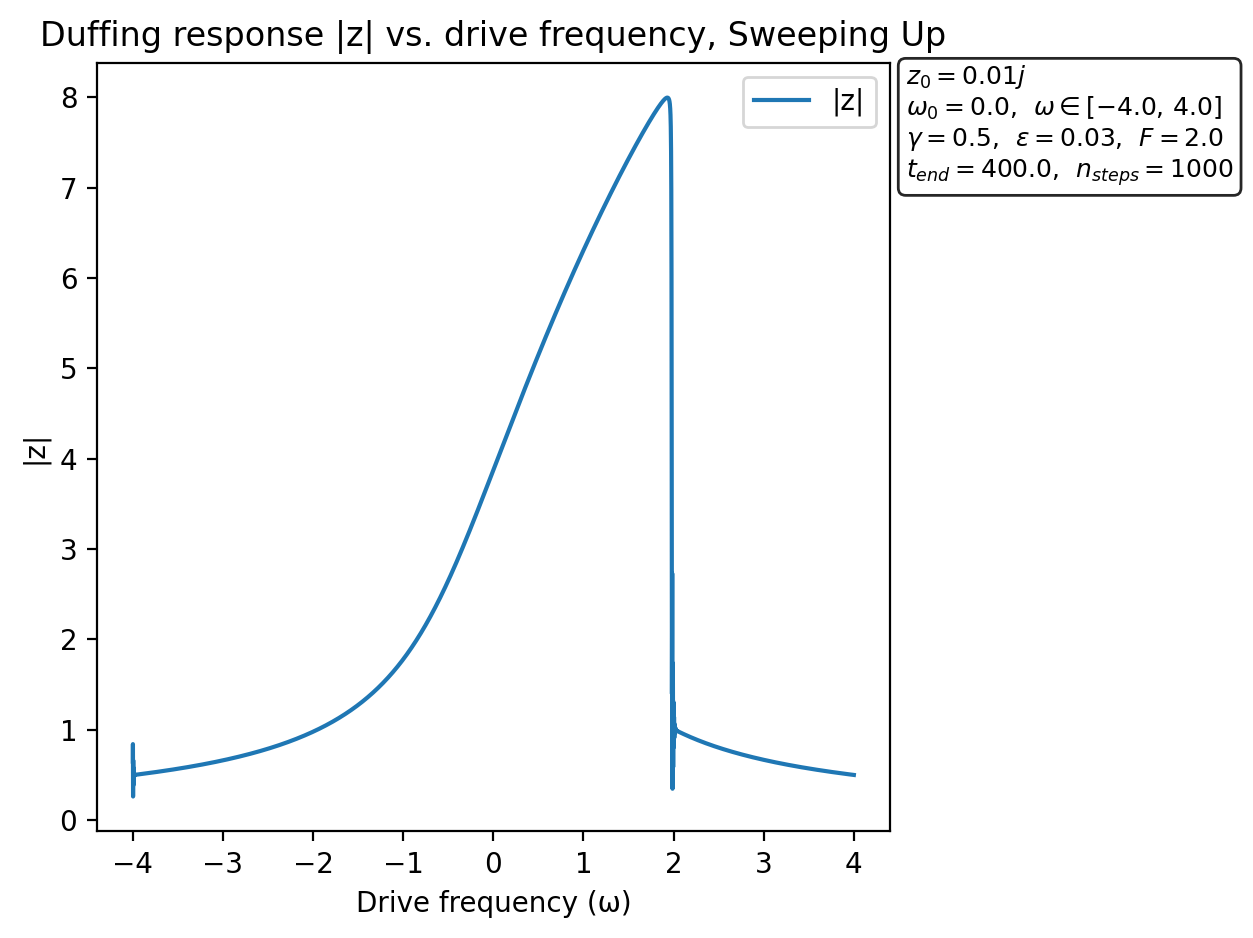

In [13]:
zs,ts,omegas = solve_duffing( 0.0+0.01j, omega0=0.0, omega_start=-4.0, 
                    omega_stop=+4.0, gamma=.5, 
                      epsilon=0.03, force=2.0, 
                      t_end=4000.0, nsteps=10000 )

params = dict(omega0=0.0, omega_start=-4.0, omega_stop=+4.0,
              gamma=0.5, epsilon=0.03, force=2.0,
              t_end=400.0, nsteps=1000)
z0 = 0.01j

# Build a multi-line label using mathtext
param_text = "\n".join([
    rf"$z_0={z0}$",
    rf"$\omega_0={params['omega0']}$,  $\omega\in[{params['omega_start']},\,{params['omega_stop']}]$",
    rf"$\gamma={params['gamma']}$,  $\epsilon={params['epsilon']}$,  $F={params['force']}$",
    rf"$t_{{end}}={params['t_end']}$,  $n_{{steps}}={params['nsteps']}$",
])

fig, ax = plt.subplots()
ax.plot(np.asarray(omegas), np.asarray(jnp.abs(zs)), label="|z|")
ax.set_title("Duffing response |z| vs. drive frequency, Sweeping Up")
ax.set_xlabel("Drive frequency (ω)")
ax.set_ylabel("|z|")

ax.text(1.02, 1.0, param_text, transform=ax.transAxes, va="top",
        fontsize=9, bbox=dict(boxstyle="round", facecolor="white", alpha=0.85))
ax.legend(loc="best")
plt.tight_layout()
plt.show()

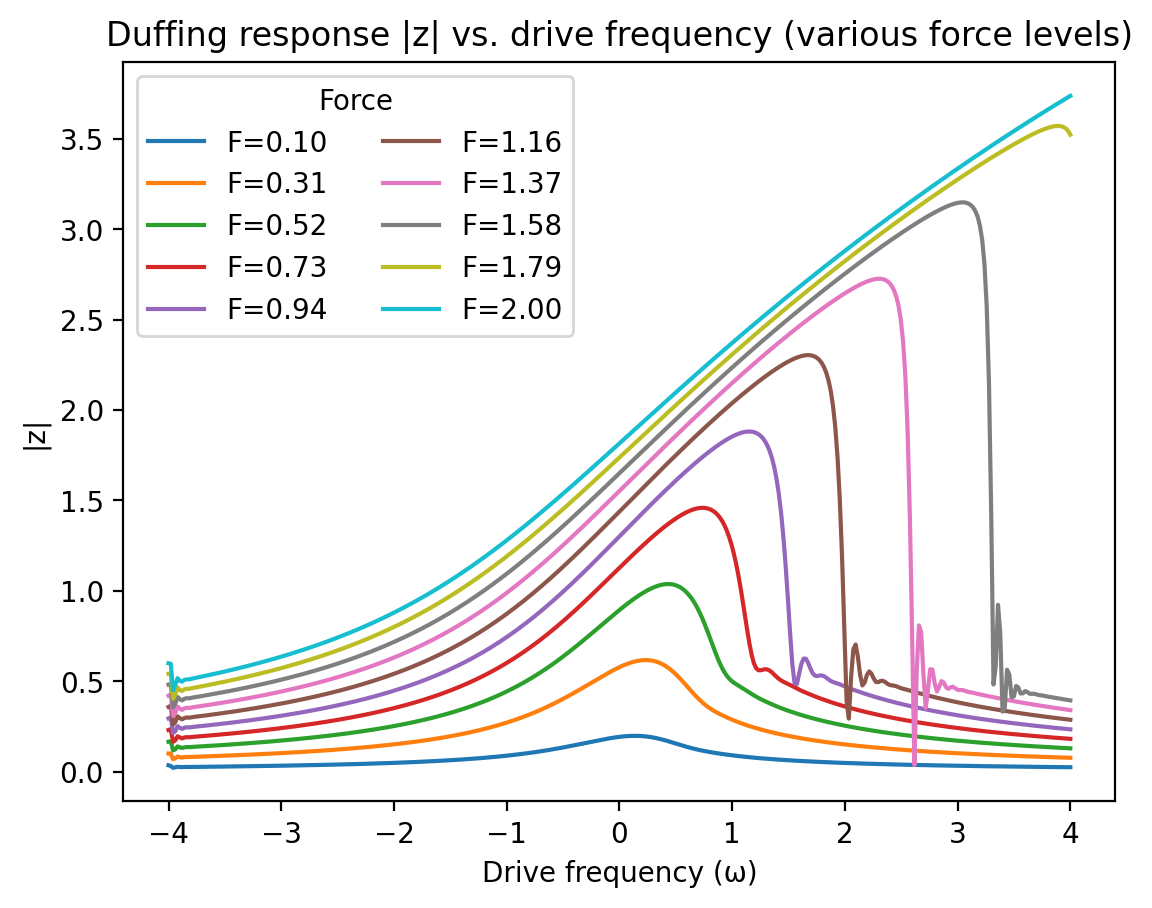

In [15]:
zs,ts,omegas = solve_duffing_force_batch( 0.0+0.01j, 0.0,
                                     1.0, 
                      0.3, jnp.linspace(0.1,2.0,10), 
                     -4.0, +4.0,
                      200.0, 400 )

forces = jnp.linspace(0.1, 2.0, 10)

fig, ax = plt.subplots()

for j, F in enumerate(np.asarray(forces)):
    ax.plot(np.asarray(omegas[j]), np.asarray(jnp.abs(zs[j])), label=f"F={F:.2f}")

ax.set_title("Duffing response |z| vs. drive frequency (various force levels)")
ax.set_xlabel("Drive frequency (ω)")
ax.set_ylabel("|z|")
ax.legend(title="Force", ncol=2)  # ncol optional
plt.show()

Now we want to be able to produce random variables in Jax. To do so we define two particular functions; one to generate a set of random vectors (for $\omega_0$, $\epsilon$, $\gamma$), and one to generate, for some given forcing, a series of Duffing Oscilator training data.    

In [16]:
def random_parameter_vectors(key, batchsize, ranges):
    """
    Produce several vectors of length batchsize between the ranges of 
    [min_size, max_size] for each parameter.
    """
    subkeys = jax.random.split( key, len(ranges) )
    return [ jax.random.uniform( subkey, [ batchsize ], 
                                      minval = value_range[0], maxval = value_range[1] )
            for subkey, value_range in zip(subkeys, ranges) ]

def duffing_produce_training_batch( key, batchsize, ranges , num_frequency_bins,
                                  force=1.0, omega_start=-4.0, omega_end=+4.0,
                                  t_end=200.0, n_steps=400):
    """
    Produce a Duffing model training batch.
    Random values for omega0, gamma, and epsilon are generated uniformly
    in the ranges given in the list 'ranges' (a list of [min_val,max_val] entries).
    
    Returns:
    x, y_target
    
    where
    
    x is of shape [batchsize, num_frequency_bins] and represents the response curves
    y_target is of shape [batchsize, 3] and gives (omega0,gamma,epsilon) for each sample
    """
    omega0s, gammas, epsilons = random_parameter_vectors( key, batchsize, ranges )
    zs,_,_ = solve_duffing_parameter_batch( 0.0+0.0j, omega0s, gammas, epsilons,
                                           force, omega_start, omega_end, t_end,
                                           n_steps)
    x = jax.image.resize( jnp.abs(zs), [ batchsize, num_frequency_bins] , "linear")
    return x, jnp.stack( [ omega0s, gammas, epsilons ], 1 )

def duffing_produce_training_batch_noise( key, batchsize, ranges,  num_frequency_bins,
                                  force=1.0, omega_start=-4.0, omega_end=+4.0,
                                  t_end=200.0, n_steps=400, noise_std=0.05):
    
    x, y_target = duffing_produce_training_batch( key, batchsize, ranges, num_frequency_bins,
                                    force, omega_start, omega_end, t_end, n_steps)

    key, subkey = jax.random.split(key)
    noise = jax.random.normal(subkey, x.shape) * noise_std
    
    return x + noise, y_target


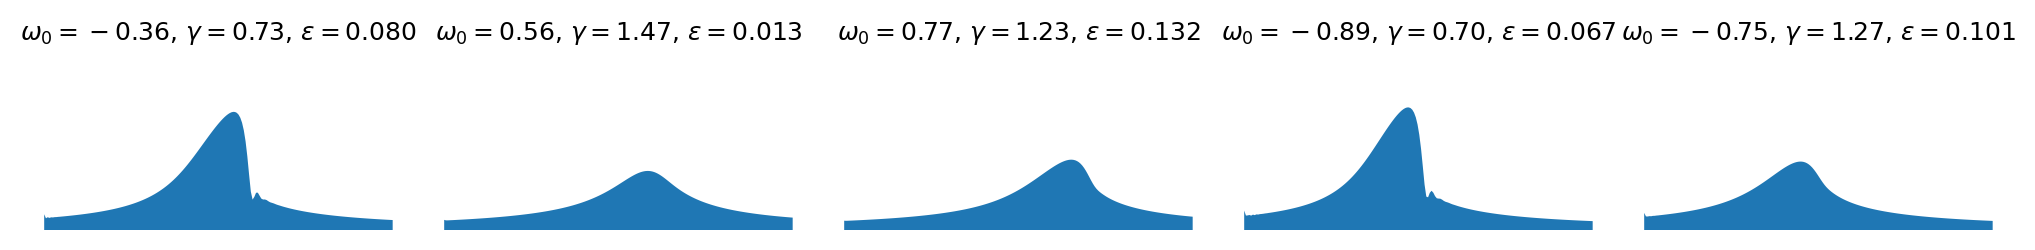

In [17]:
key = jax.random.key(44)
num_panels = 5
npixels = 200

x, y_target = duffing_produce_training_batch(
    key, num_panels,
    [[-1., 1.], [0.5, 1.5], [0.0, 0.15]],
    npixels
)

omegas = jnp.linspace(-4., 4., npixels)
fig, ax = plt.subplots(ncols=num_panels, sharey=True, figsize=(10, 2), constrained_layout=True)

for idx in range(num_panels):
    ax[idx].fill_between(np.asarray(omegas), 0, np.asarray(x[idx, :]))
    ax[idx].set_ylim(0., 4.)
    ax[idx].set_aspect(1.0)
    ax[idx].axis('off')

    omega0, gamma, epsilon = map(float, np.asarray(y_target[idx, :]))
    ax[idx].set_title(rf"$\omega_0={omega0:.2f}$, $\gamma={gamma:.2f}$, $\epsilon={epsilon:.3f}$",
                      fontsize=9)

plt.show()

Alright, now we define the Neural Network as we did earlier in Lesson 2. Then we similarly batch it (vmap), define the loss, and jit the loss. 

In [18]:
def NN(x, params):
    num_layers = len(params['weights'])
    for layer_idx, (w,b) in enumerate(zip(params['weights'], params['biases'])):
        x = jnp.matmul(w, x) + b
        if layer_idx < num_layers - 1:
            x = jnp.tanh(x)
    return x

NN_batch = vmap(NN, in_axes=[0,None], out_axes=0)

def mse_loss_batch(x, y_target, params):
    return jnp.sum( (NN_batch(x, params) - y_target)**2 ) / jnp.shape(x)[0]

mse_loss_batch_val_grad = jax.jit( value_and_grad(mse_loss_batch, argnums=2) )

Now we have the NN_batch that serves as our batched network and mse_loss_batch_val_grad that serves as the calculation of our loss function (and its gradient). So all that's left is predefining some parameters, some ranges, and setting up the training.

In [19]:
num_frequency_bins = 50 # will be input dimension
num_physics_parameters = 3 # output dimension
learning_rate = 1e-3

key = jax.random.key( 42 )

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, [num_frequency_bins, 100, num_physics_parameters] )

optimizer = optax.adam( learning_rate )
opt_state = optimizer.init( params )

In [21]:
# training parameters
num_training_batches = 1500
batchsize = 32
value_ranges = [[-1.,1.],[0.5,1.5],[0.0,0.15]] # omega0, gamma, epsilon
losses=[]

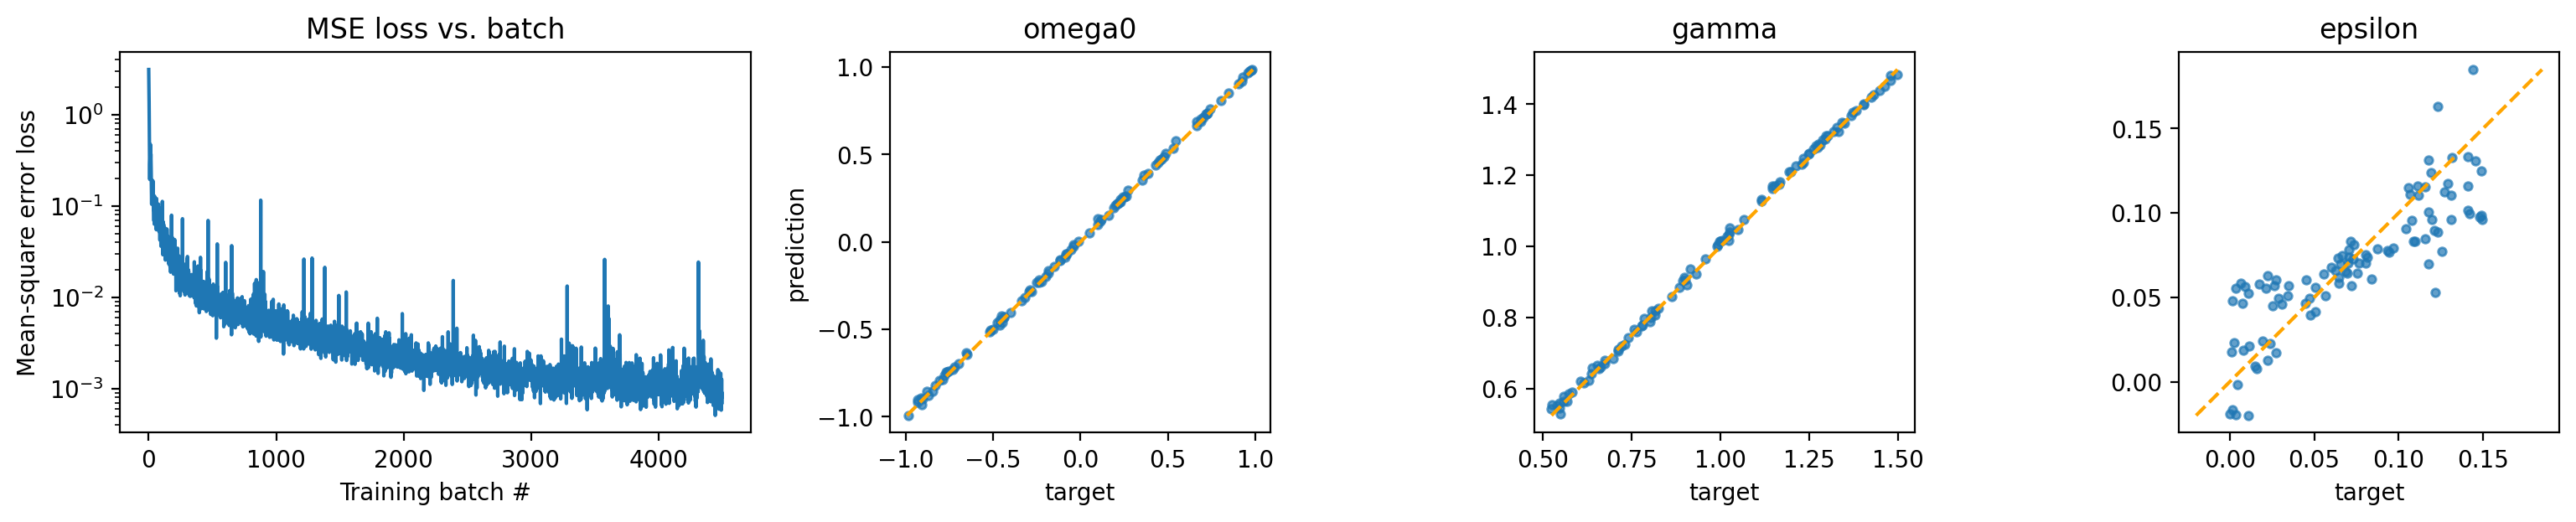

In [24]:
# run this cell multiple times to continue training!

for idx_batch in range(num_training_batches):
    # get training batch:
    subkey,key = jax.random.split( key )
    x, y_target = duffing_produce_training_batch( subkey, batchsize, 
                                                 value_ranges, num_frequency_bins)
        
    # get loss and its gradient with respect to network parameters:
    loss, grads = mse_loss_batch_val_grad( x, y_target, params )

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state)
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)

# 1) Build a single row of 4 subplots
fig, ax = plt.subplots(ncols=4, figsize=(16, 3), constrained_layout=True)

# --- [0] Loss curve ---
ax[0].plot(np.asarray(losses))
ax[0].set_yscale("log")
ax[0].set_title("MSE loss vs. batch")
ax[0].set_xlabel("Training batch #")
ax[0].set_ylabel("Mean-square error loss")

# 2) Make a fresh batch for the scatter diagnostics
key, subkey = jax.random.split(key)
x, y_target = duffing_produce_training_batch(
    subkey, 100, value_ranges, num_frequency_bins
)
y = NN_batch(x, params)

# --- [1..3] Scatter: target vs prediction for each param ---
labels = ["omega0", "gamma", "epsilon"]
for i, label in enumerate(labels, start=1):
    t = np.asarray(y_target[:, i-1]).ravel()  # targets
    p = np.asarray(y[:, i-1]).ravel()         # predictions

    ax[i].scatter(t, p, s=12, alpha=0.7)
    # diagonal y=x for reference
    lo = np.min(np.concatenate([t, p]))
    hi = np.max(np.concatenate([t, p]))
    pad = 0.05 * (hi - lo) if hi > lo else 1.0
    ax[i].plot([lo, hi], [lo, hi], "--", color="orange")
    ax[i].set_xlim(lo - pad, hi + pad)
    ax[i].set_ylim(lo - pad, hi + pad)
    ax[i].set_aspect("equal", adjustable="box")
    ax[i].set_title(label)
    ax[i].set_xlabel("target")
    if i == 1:
        ax[i].set_ylabel("prediction")

plt.show()

Now let's analyse the effect of noise onto the system. Above (right below the original definition of the training batch function) define a noisy variant that adds a bit of gaussian noise and feed that into the Neural Network as opposed to the original function and analyse the effects

omega0: NaN t=0, NaN p=0, Inf t=0, Inf p=0, t range=(-1,0.984), p range=(-0.963,0.951)
gamma: NaN t=0, NaN p=0, Inf t=0, Inf p=0, t range=(0.536,1.48), p range=(0.424,1.46)
epsilon: NaN t=0, NaN p=0, Inf t=0, Inf p=0, t range=(0.00292,0.139), p range=(-0.0461,0.147)


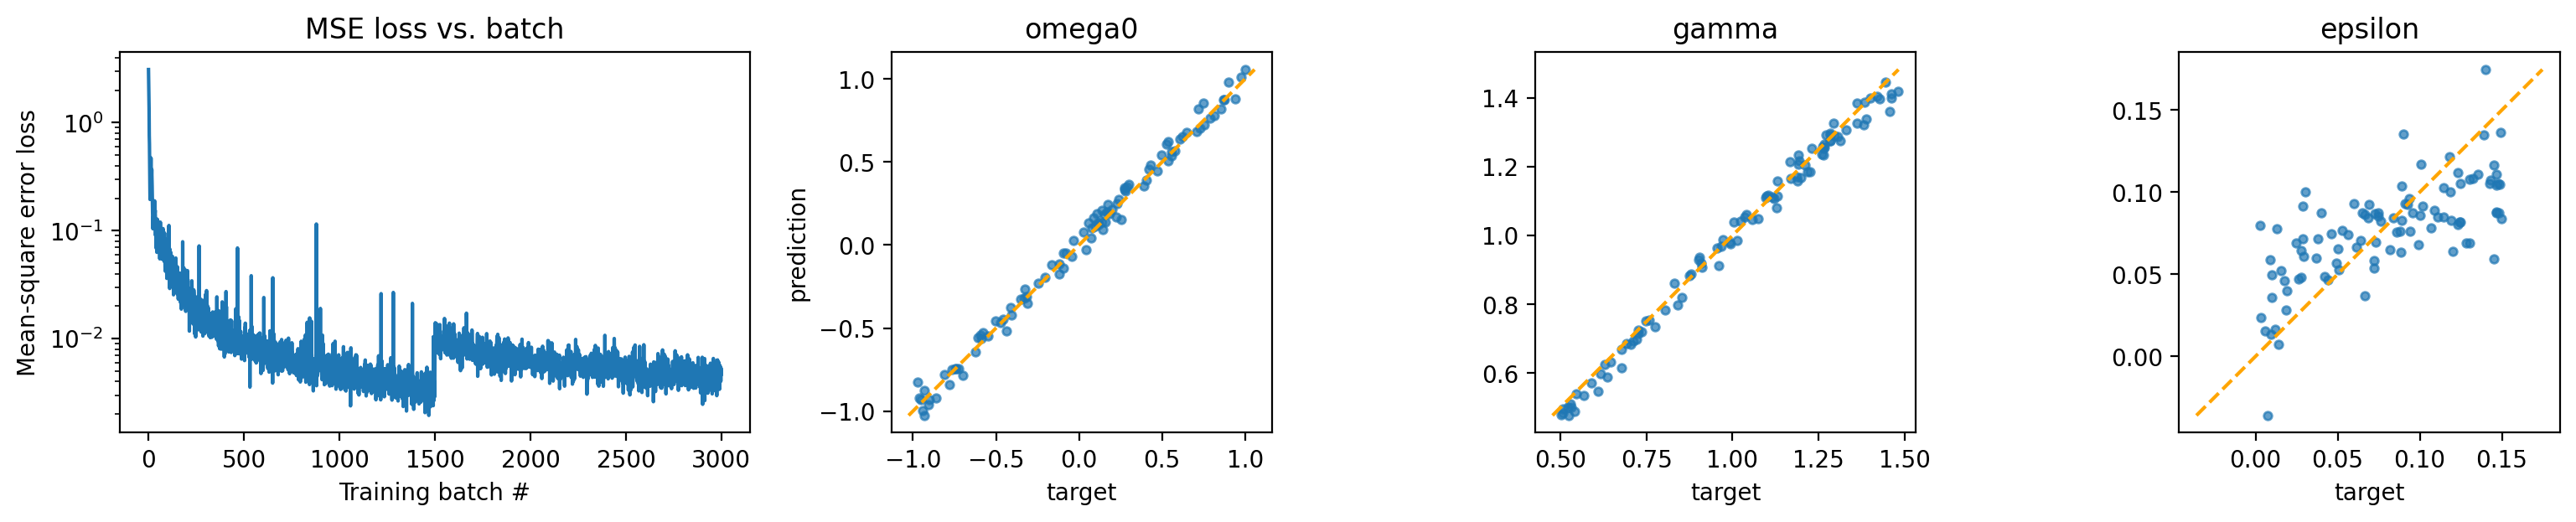

In [13]:
# run this cell multiple times to continue training!

for idx_batch in range(num_training_batches):
    # get training batch:
    subkey,key = jax.random.split( key )
    x, y_target = duffing_produce_training_batch_noise( subkey, batchsize, 
                                                  [[-1., 1.], [0.5, 1.5], [0.0, 0.15]], num_frequency_bins)
        
    # get loss and its gradient with respect to network parameters:
    loss, grads = mse_loss_batch_val_grad( x, y_target, params )

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state)
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)
labels = ["omega0","gamma","epsilon"]
Yt = np.asarray(y_target, dtype=float)
Yp = np.asarray(y,        dtype=float)

for i, label in enumerate(labels):
    t = Yt[:, i]; p = Yp[:, i]
    print(f"{label}: NaN t={np.isnan(t).sum()}, NaN p={np.isnan(p).sum()}, "
          f"Inf t={np.isinf(t).sum()}, Inf p={np.isinf(p).sum()}, "
          f"t range=({np.nanmin(t):.3g},{np.nanmax(t):.3g}), "
          f"p range=({np.nanmin(p):.3g},{np.nanmax(p):.3g})")
    
# 1) Build a single row of 4 subplots
fig, ax = plt.subplots(ncols=4, figsize=(16, 3), constrained_layout=True)

# --- [0] Loss curve ---
ax[0].plot(np.asarray(losses))
ax[0].set_yscale("log")
ax[0].set_title("MSE loss vs. batch")
ax[0].set_xlabel("Training batch #")
ax[0].set_ylabel("Mean-square error loss")

# 2) Make a fresh batch for the scatter diagnostics
key, subkey = jax.random.split(key)
x, y_target = duffing_produce_training_batch_noise(
    subkey, 100, value_ranges, num_frequency_bins
)
y = NN_batch(x, params)

# --- [1..3] Scatter: target vs prediction for each param ---
labels = ["omega0", "gamma", "epsilon"]
for i, label in enumerate(labels, start=1):
    t = np.asarray(y_target[:, i-1]).ravel()  # targets
    p = np.asarray(y[:, i-1]).ravel()         # predictions

    ax[i].scatter(t, p, s=12, alpha=0.7)
    # diagonal y=x for reference
    lo = np.min(np.concatenate([t, p]))
    hi = np.max(np.concatenate([t, p]))
    pad = 0.05 * (hi - lo) if hi > lo else 1.0
    ax[i].plot([lo, hi], [lo, hi], "--", color="orange")
    ax[i].set_xlim(lo - pad, hi + pad)
    ax[i].set_ylim(lo - pad, hi + pad)
    ax[i].set_aspect("equal", adjustable="box")
    ax[i].set_title(label)
    ax[i].set_xlabel("target")
    if i == 1:
        ax[i].set_ylabel("prediction")

plt.show()

Before moving onto a slightly more complicated setup involving the force and 2D sweeps as well, the lesson goes into a bit of detail regarding training with minimal data. In order to do this they use an epoch set up where they have a set amount of data that they shuffle around after all the batches have been processed. So effectivley the only difference is another loop in the training where we itterate over the batches inside of another loop itterating over the epochs, and we make sure that the order in which the batches are sampled are randomized per epoch

In [14]:
num_training_samples = 64
train_x, train_y_target = duffing_produce_training_batch( subkey, num_training_samples, 
                                             value_ranges, num_frequency_bins)

epoch_indices = jax.random.choice(subkey,jnp.arange(num_training_samples), 
    (num_training_samples,), replace=False)

num_frequency_bins = 50 # will be input dimension
num_physics_parameters = 3 # output dimension
learning_rate = 1e-3

key = jax.random.key( 42 )

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, [num_frequency_bins, 100, num_physics_parameters] )

optimizer = optax.adam( learning_rate )
opt_state = optimizer.init( params )

# training parameters
num_training_epochs = 1000
batchsize = 16
num_batches_per_epoch = num_training_samples//batchsize

value_ranges = [[-1.,1.],[0.5,1.5],[0.0,0.15]] # omega0, gamma, epsilon
losses=[]

Now we run the simulations and plot the graphs

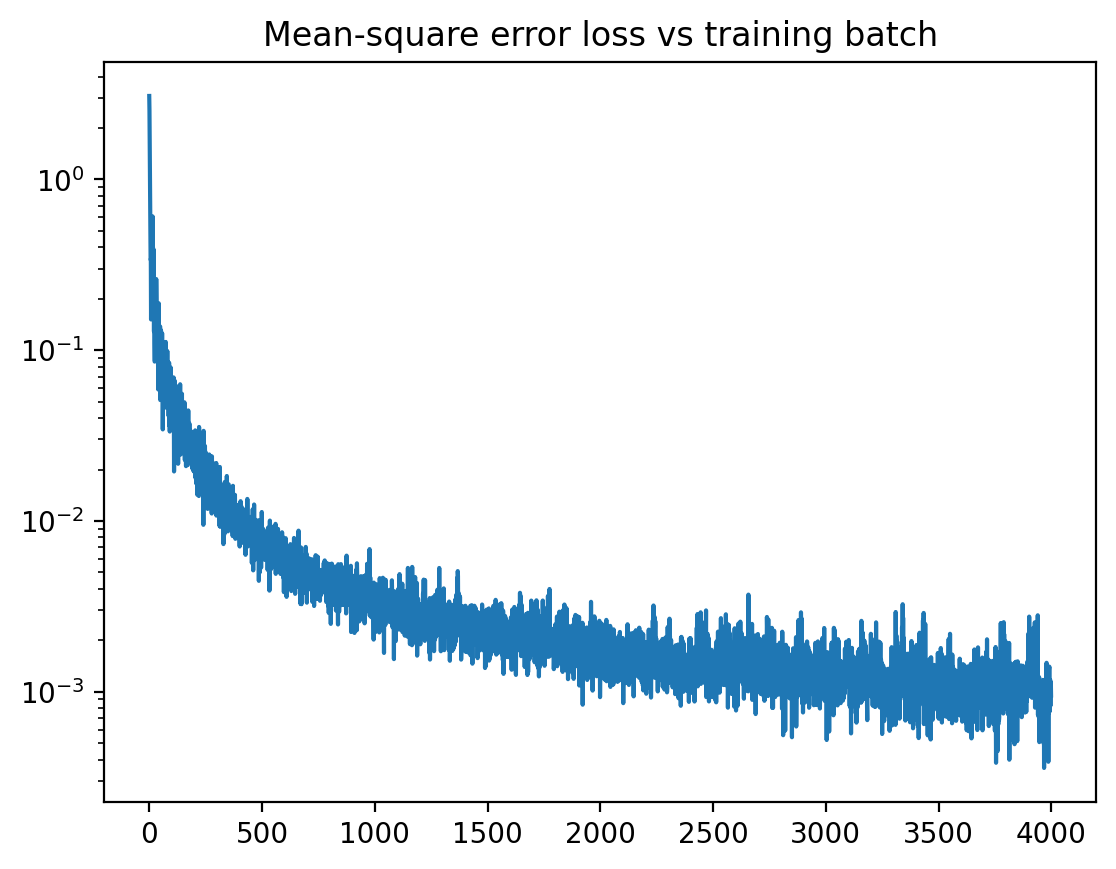

In [15]:
# run this cell multiple times to continue training!

for idx_epoch in range(num_training_epochs):
    # get a random permutation of sample indices:
    subkey,key = jax.random.split( key )
    epoch_indices = jax.random.choice(subkey, 
                        jnp.arange(num_training_samples), 
                        (num_training_samples,), replace=False)

    for idx_batch in range(num_batches_per_epoch):
        # get training batch:
        indices_batch = epoch_indices[idx_batch*batchsize:(idx_batch+1)*batchsize]
        x, y_target = train_x[indices_batch], train_y_target[indices_batch]

        # get loss and its gradient with respect to network parameters:
        loss, grads = mse_loss_batch_val_grad( x, y_target, params )

        # update the network parameters:
        updates, opt_state = optimizer.update( grads, opt_state)
        params = optax.apply_updates( params, updates )

        # add the loss to the list:
        losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()

Evaluation on training data set


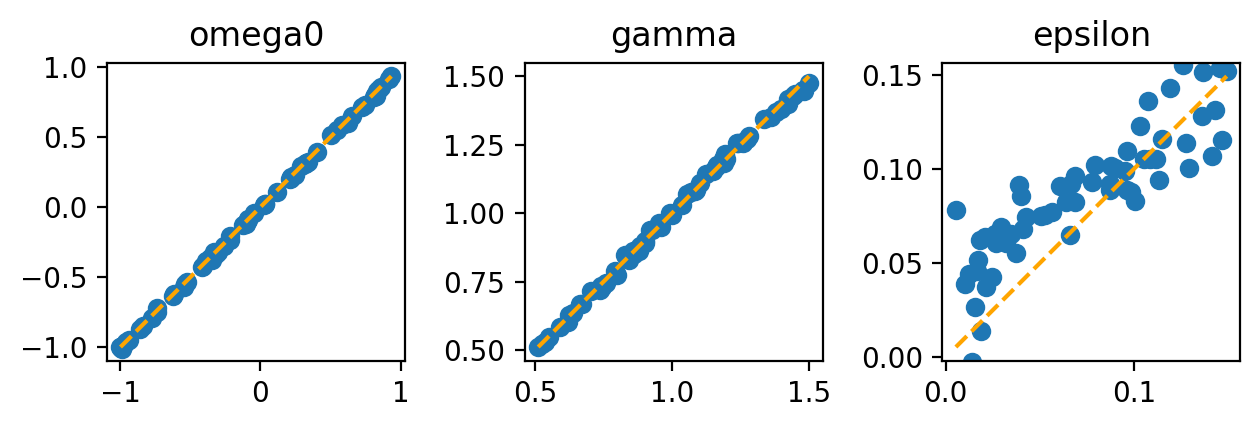

Evaluation on fresh data set


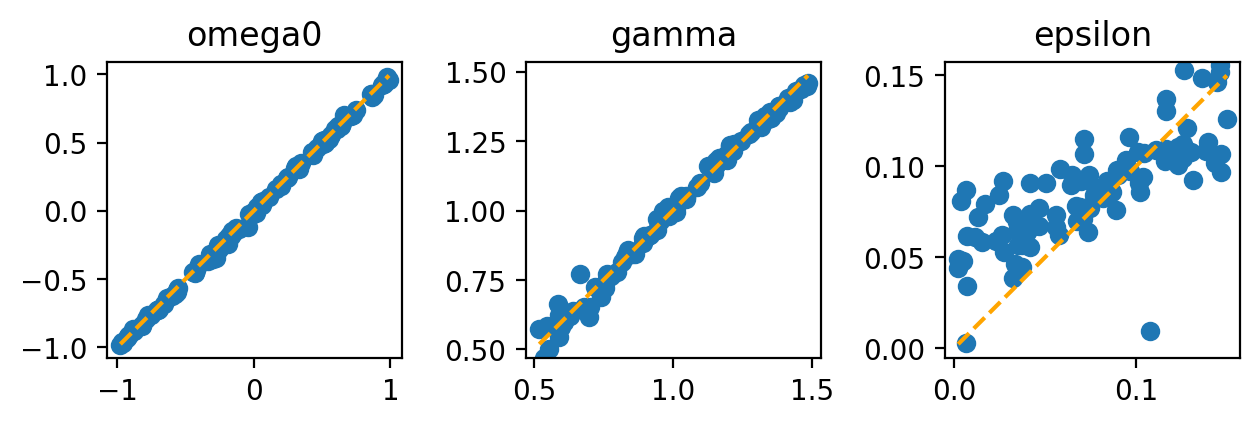

In [16]:
for idx_figure in range(2):
    if idx_figure==0:
        x, y_target = train_x, train_y_target
        print("Evaluation on training data set")
    else:
        subkey,key = jax.random.split( key )
        x, y_target = duffing_produce_training_batch( subkey, 100, 
                                                 value_ranges, num_frequency_bins)
        print("Evaluation on fresh data set")

    y = NN_batch(x,params)
        
    fig,ax = plt.subplots(ncols=3)
    for idx, label in enumerate(["omega0","gamma","epsilon"]):
        ax[idx].scatter(y_target[:,idx],y[:,idx])
        min_max_values=[jnp.min(y_target[:,idx]),jnp.max(y_target[:,idx])]
        ax[idx].plot(min_max_values,min_max_values,"--",color="orange")
        ax[idx].set_ylim(ax[idx].get_xlim())
        ax[idx].set_title(label)
        ax[idx].set_aspect(1.0)
    fig.tight_layout()
    plt.show()

The problem here is that the training data set is vastly overperforming the fresh data set as the training goes longer and longer. The reason this is a problem is because it means that instead of learning new bits of information, its simply memorizing elements of the set. As such the behaviour, while seemingly more accurate, is less generalizable. The lesson offers 3 solutions to this problem
- Keep a portion of the limited data set seperate from the neural net and only use it for validation proposes. The networks performance is is evaluated with respect to how well it performs with regards to validation set. Training is stopped when the performance on the validation set stops improving (i.e. early stopping)
- Add noise into your network activation. This is called dropout
- You can also completely remove a bit of data and use it after the training to independantly validate the network, not even using it for validation purposes.

I'll try 2/3 of these 

Now let's consider the effects of force and how we can fit that as well. The first is to perform a frequency sweep similar to what we were doing for the parameters but instead of a variety of forces, and produce a 2D map of the response. The sovlve_duffing function already performs a frequency sweep, and the force batched variant allows for us to also sweep for increasing force.

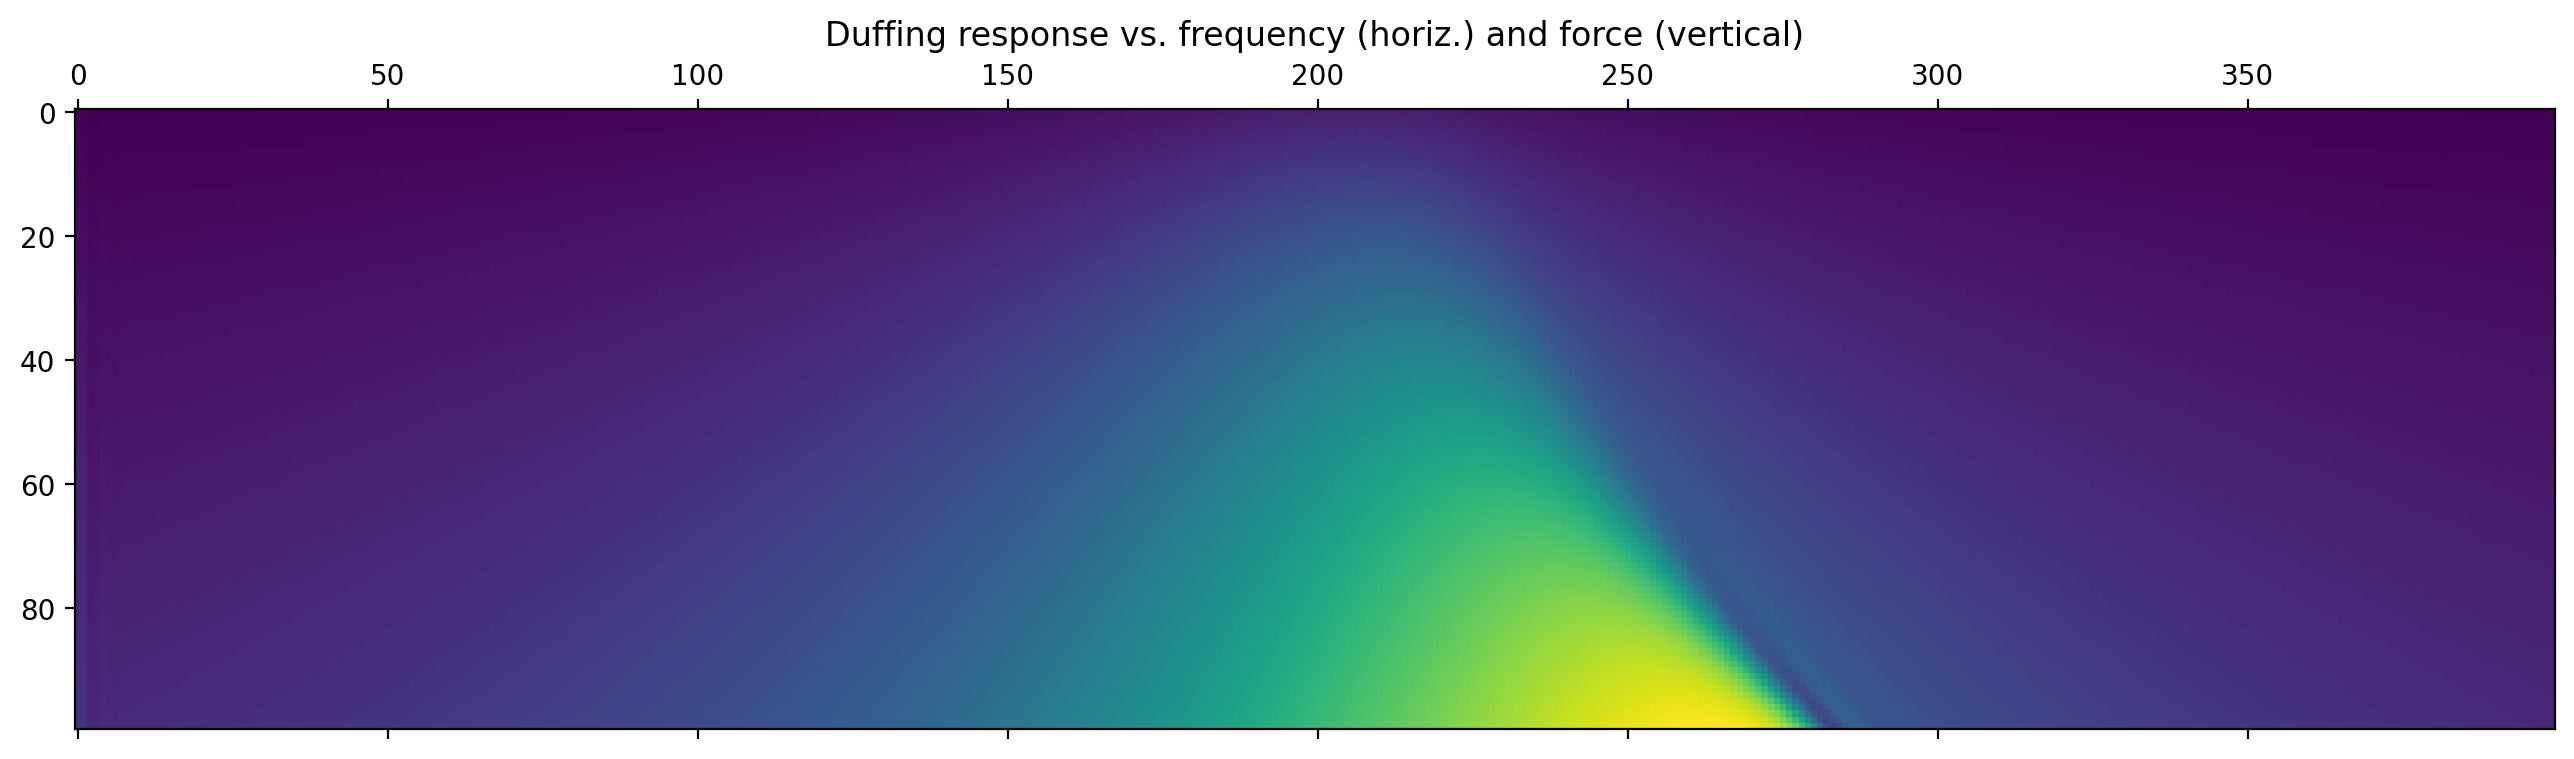

In [17]:
zs,ts,omegas = solve_duffing_force_batch( 0.0+0.01j, 0.0, 1.0, 
                      0.3, jnp.linspace(0.1,1.0,100), -4.0, 
                    +4.0,
                      200.0, 400 )

plt.matshow( jnp.abs(zs) )
plt.title("Duffing response vs. frequency (horiz.) and force (vertical)")
plt.show()

What we want to do here is to get into convolutional neural networks. We want to be able to feed into the eventual convolutional neural net a series of "pictures" (ala plot above) instead of curves (last example). So The first step is also going to be analagously producing training data for random parameters. So we're going to be sweeping over a range of forces for a variety of $\omega_0$, $\gamma$, and $\epsilon$ to generate a variety of pictures. The lesson also goes one step further and adds noise straight up 

In [18]:
def produce_force_sweep_image(key, omega0,epsilon,gamma, npixels, 
                              omega_range, low_force, high_force, 
                              t_end, nsteps, noise_strength):
    zs,ts,omegas = solve_duffing_force_batch( 0.0+0.01j, omega0, gamma, 
                      epsilon, jnp.linspace(low_force,high_force,npixels), -omega_range, +omega_range,
                      t_end, nsteps )
    # downscale image (less data for the network to process):
    resized_img = jax.image.resize(jnp.abs(zs), (npixels,npixels), "cubic")
    # add noise:
    resized_img+= noise_strength * jax.random.normal(key, jnp.shape(resized_img) )
    
    # also produce images containing the frequency values
    # and the force values:
    freq_img = jnp.repeat( jnp.linspace(-omega_range, 
                            +omega_range, npixels)[None,:], npixels, axis=0 )
    force_img = jnp.repeat( jnp.linspace(low_force, 
                            high_force, npixels)[:,None], npixels, axis=1 )
    # stack all three images together, so that
    # the resulting axis 0 will represent the three channels:
    return jnp.stack( [resized_img, freq_img, force_img], axis=0 )

# a batched version,
# also compiled for speedup.
# for jit, static_argnums=[3,8] says that arguments index 4 and 9, 
# "npixels" and "nsteps" are static parameters
# and not jax arrays. If these change,
# a recompilation will be triggered automatically.
produce_force_sweep_image_batch = jax.jit( vmap( produce_force_sweep_image, 
                                       in_axes=[0,0,0,0,None,None,None,None,None,None,None], out_axes=0),
                                         static_argnums=[4,9])


# the function that puts everything together
# and will be called during the training loop:
def get_duffing_image_batch(key, batchsize, ranges, 
                            npixels, omega_range, 
                            low_force, high_force, t_end, nsteps,
                            noise_strength):
    subkey1, subkey2 = jax.random.split( key )
    omega0s, gammas, epsilons = random_parameter_vectors( subkey1, batchsize, ranges )
    
    # need to get many random keys, one for each
    # noisy sample in the batch:
    subkeys = jax.random.split( subkey2, batchsize )
    output = produce_force_sweep_image_batch( subkeys, omega0s,epsilons,gammas, 
                                        npixels, omega_range, 
                                        low_force, high_force, 
                                        t_end, nsteps, noise_strength )
    return ( output, jnp.stack([omega0s,gammas,epsilons], axis=1) )

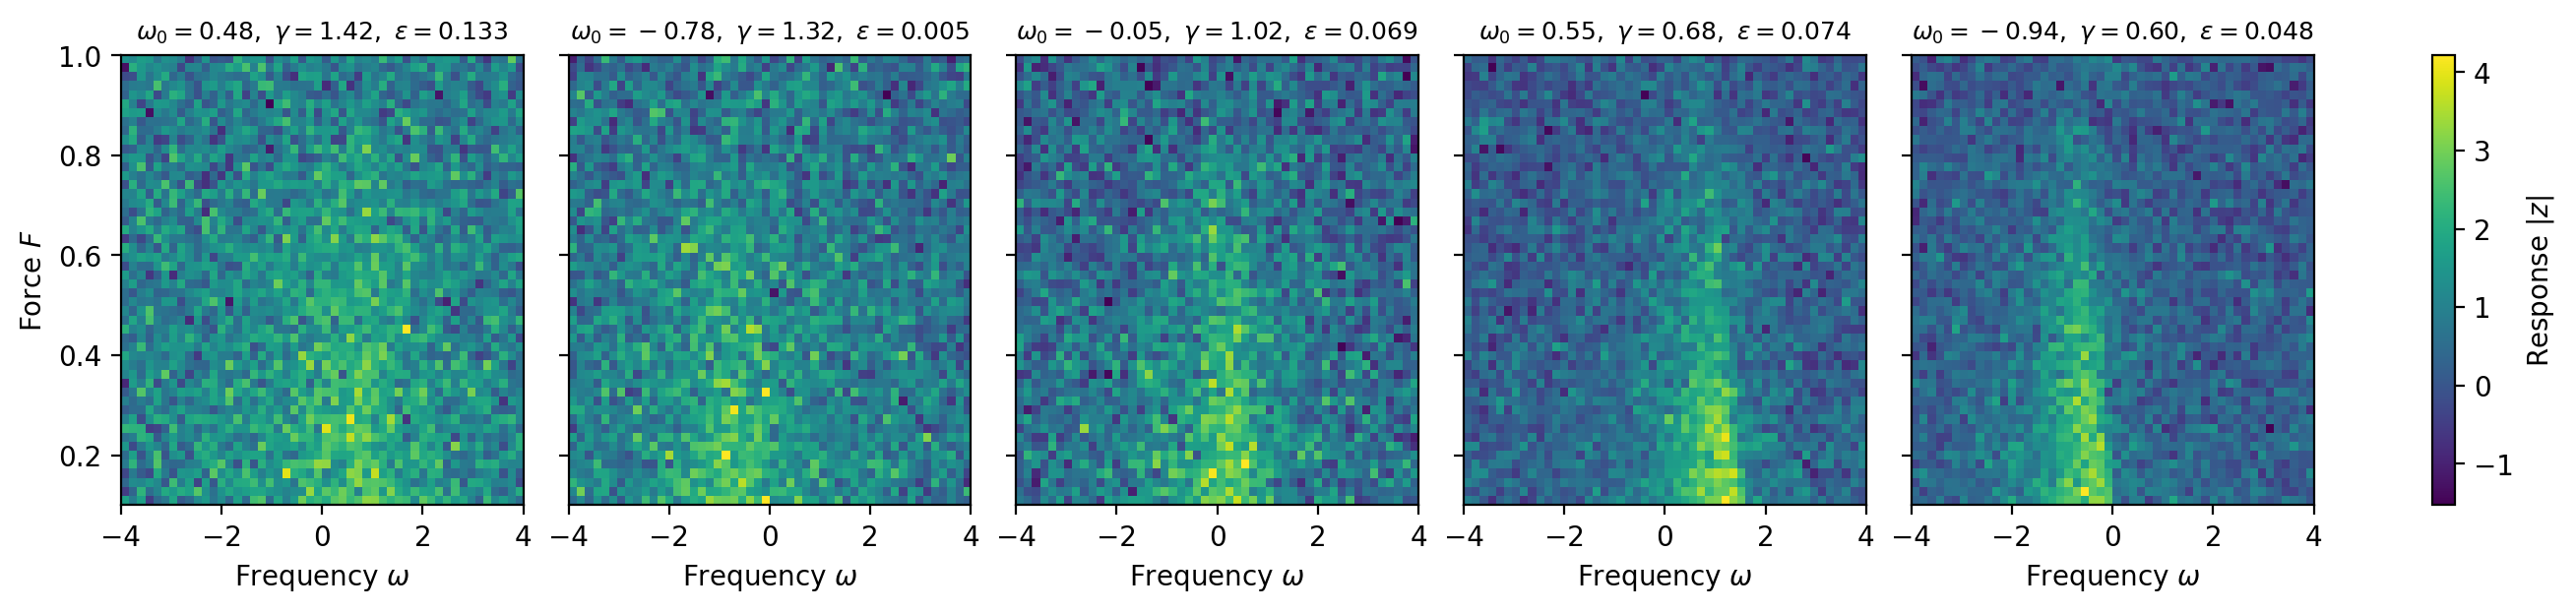

In [19]:
subkey, key = jax.random.split(key)
img_batch,y_target = get_duffing_image_batch( subkey, 5, value_ranges, 
                        50, 4.0, 0.1, 1.0, 200., 400, 0.5)

B = 5
npixels = 50
omega_range = 4.0
low_force, high_force = 0.1, 1.0

# Figure layout
fig, ax = plt.subplots(ncols=B, figsize=(13, 3), sharex=True, sharey=True, constrained_layout=True)

# Decide how to index the response channel (CHW vs HWC)
is_chw = (img_batch.ndim == 4 and img_batch.shape[1] == 3)  # (B, C, H, W)
def resp_image(j):
    return img_batch[j, 0] if is_chw else img_batch[j, :, :, 0]

extent = [-omega_range, +omega_range, low_force, high_force]

# Plot each panel
for j in range(B):
    im = ax[j].imshow(np.asarray(resp_image(j)),  # response |z|
                      extent=extent, origin="upper", aspect="auto")
    # Label axes (leftmost+all bottoms to avoid clutter)
    if j == 0:
        ax[j].set_ylabel("Force $F$")
    ax[j].set_xlabel("Frequency $\\omega$")

    # Show the parameters used for this image
    ω0, γ, ε = map(float, np.asarray(y_target[j]))
    ax[j].set_title(rf"$\omega_0={ω0:.2f},\ \gamma={γ:.2f},\ \epsilon={ε:.3f}$", fontsize=9)

# One shared colorbar
fig.colorbar(im, ax=ax.ravel().tolist(), label="Response $|z|$")
plt.show()

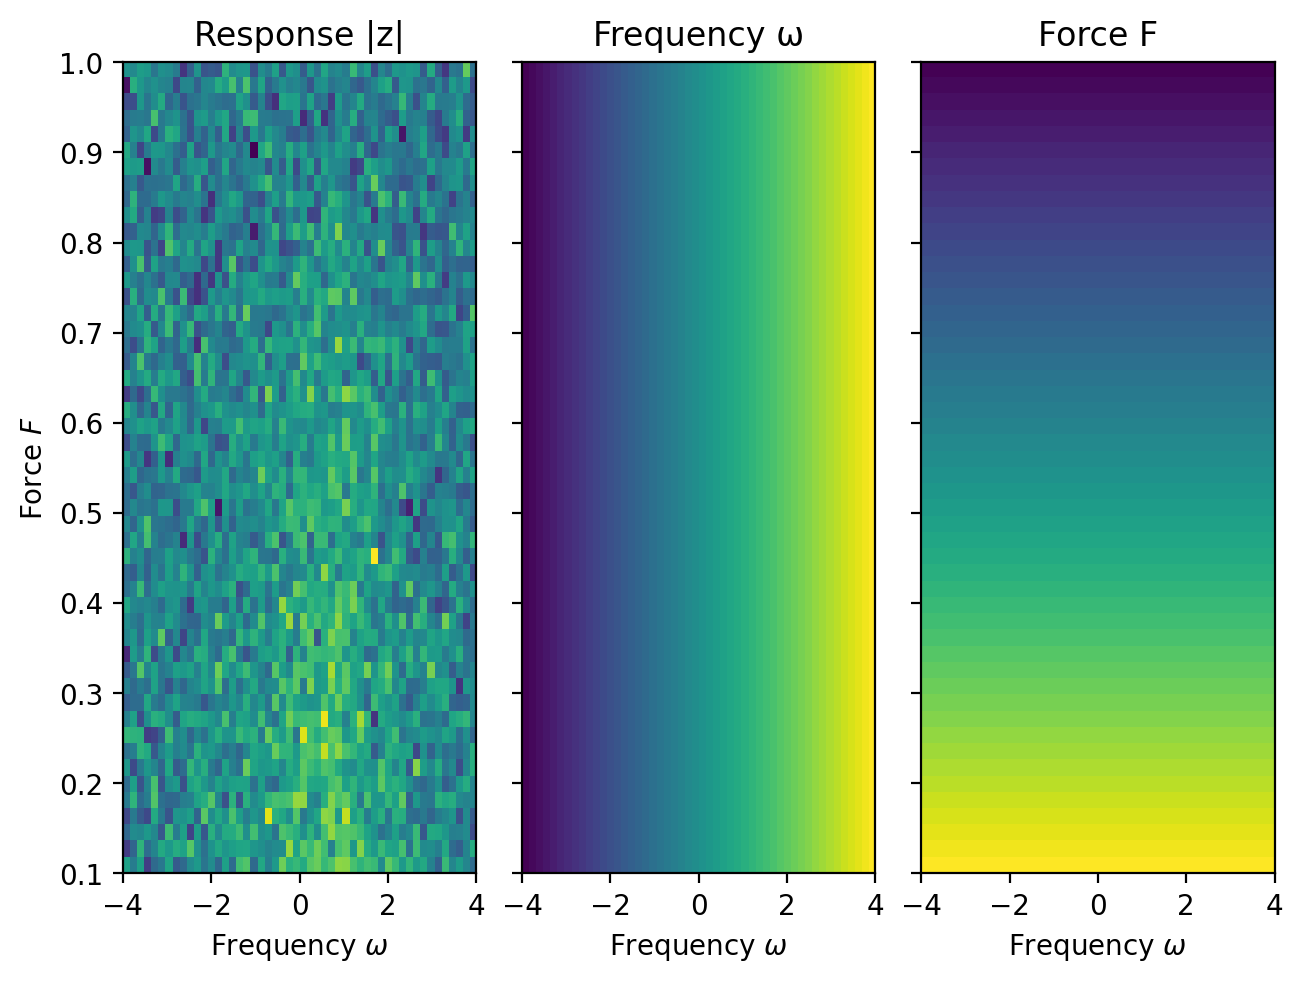

In [20]:
fig,ax=plt.subplots(ncols=3, sharex= True, sharey= True, constrained_layout=True)

extent = [-omega_range, +omega_range, low_force, high_force]
titles = ["Response |z|", "Frequency ω", "Force F"]

for j in range(3):
    ax[j].imshow(img_batch[0,j],
    extent = extent,
    origin = "upper",
    aspect = "auto",
    cmap='viridis')
    ax[j].set_title(titles[j])
    ax[j].set_xlabel("Frequency $\\omega$")
    if j == 0:
        ax[j].set_ylabel("Force $F$")

plt.show()

Alright all of this sets up the backbone of what needs to be done. The issue with using a regular neural net as its been done before is that even an image as simple as this has 2500 pixles. Meaning if we were to try to input a singular chanel of even one data point, we'd need an input dimention of 2500. This is a tad unreasonable and any next layer we'd have would also need connections coming out of each of those 2500 neurons. A convolutional neural net exploits the translational invaraince of pictures. Meaning that irrespective of where in a picture an entitiy is present, that entity remains present. If that entitiy is representitive of something, then, its presence in the picture is as meaningful wheter its in one corner of the picture or the other. 

The core processes behind a convolutional neural net is as follows. You sweep across an imagine with a kernel of size [K,K], performing a convolution of the pixel values of the imagine by multiplying them with the weight values in the kernel. While this is regularly how imagine processing gets handeled anyhow, the main difference here in that the weights (and biases) in the kernel are learnable parameters. If the image has multiple channels as opposed to simply being a flat 2D image (as it does above) then the kernel which has to convert an N chanell input to an M channel input has to have the shape [N, M, K, K]. 

The final item of consideration with regards to theory is how to treat edge cases. In essence, do you want the kernel to fit onto a pixel at any position in which it can fit onto it or do you want the kernel to only fit onto pixels it would otherwise fit onto perfectly (so do you want to trade additional information to preserve the dimentionality of your image). 

Jax has built in helper functions and commands with regards to convolution and setting up kernerls, so the step by step process is going to be very similar to how it was done before but the definition of the neural net is going to have to change (obviously) and a couple additional functions are going to have to be defined to make life easier. If you want to oversize and later alter the image size, use "VALID". If you want to keep everything as is and neglect the additional data, use "SAME". Nevertheless the core essence of the analysis is still:
- Produce batchable data of what you want to train for (already done above)
- Define your neural net for whatever form/ architecture that you want
- Define a Jit-table loss function that comapres your target to your current state
- Set up a training loop that itterates over your data 

In [21]:
def conv2d( img, kernel, scalefactor ):
    """
    Shortcut for jax convolution of kernel with
    image 'img', with padding 'VALID' and possibly scaling down by
    a factor (which should ideally divide the img size).
    """
    return jax.lax.conv_general_dilated(
    img, kernel, [scalefactor,scalefactor], "VALID")

At some point in the anaylsis, we're going to want to swap from a (convuvled but nevertheless still) 2D image to a series of vectors. Ultiamtely we're not trying to come up with a different 2D image from our input of a 2D image. We're trying to go from pixel values to parameters to be estimated. As such there will have to come a stage in the neural network achitecture definition that we go from a convuvled 2D image to a flatened vector. After achieving that vector, the rest is the same as what has been done before. 

In [22]:
def NN_conv( x, params ):
    """
    Apply several convolutional layers and then
    switch to fully connected. The structure here
    is fixed.
    
    params must contain params['conv_kernels'],
    params['conv_biases'] for the convolutional
    part and params['dense'] containing weights
    and biases for the dense part.
    """
    # first add a fake batch dimension, because we
    # will deal with batching separately later
    # using vmap, but jax.lax.conv needs a batch
    # dimension (here of size 1):
    x = x[None,...]
    
    # apply several 2d convolutions and downscalings by
    # factor of 2:
    for kernel, bias in zip(params['conv_kernels'],params['conv_biases']):
        x = conv2d( x, kernel, 2 ) + bias[None,:,None,None]
        x = jnp.tanh( x )
        
    # now switch to dense network, "flattening"
    # the image and its channels into a single vector
    x = jnp.reshape( x, [-1] )
    
    # finally, apply the usual dense network,
    # with its weights and biases provided
    # inside params['dense']:
    return NN( x, params['dense'] )

In [23]:
# produce a batched version (where x has a batch dimension 0)
NN_conv_batch = vmap(NN_conv, in_axes=[0,None], out_axes=0)

# batch-averaged mean-square-error deviation between network output and y_target:
def mse_loss_conv_batch(x, y_target, params):
    return jnp.sum( ( NN_conv_batch(x,params) - y_target )**2 ) / jnp.shape(x)[0]

# take gradient with respect to params (argument number '2' out of 0,1,2)
# also return value of loss. Apply jit to compile it:
mse_loss_conv_batch_val_grad = jax.jit( value_and_grad(mse_loss_conv_batch, argnums=2) )

Now comes the initilization of the network. What the lesson calls the "dense" part reffers to when the image has to be flatened. 

In [24]:
def NN_conv_init_params( key, pixel_rows, pixel_cols,
                        num_channels, kernel_sizes,
                        final_dense_layers ):
    """
    Randomly initialize the parameters needed for
    a convolutional+dense neural network.
    
    key: jax random key
    pixel_rows, pixel_cols: dimensions of input image
       (needed to properly set up the dense part!)
    num_channels: list of channels for the conv. part,
       starting with the input image channels
    kernel_sizes: listing the sizes of the kernels,
       a list of length one less than num_channels
    final_dense_layers: list of numbers of neurons in
       the final few dense layers (excluding the
       first dense layer, which results from flattening
       the convolutional output, whose neuron number is
       computed automatically from the image dim.
       given above)
       
    Returns params dictionary with entries
    'conv_kernels', 'conv_biases', and 'dense'.
    """
    params = {}
    params['conv_kernels']=[]
    params['conv_biases']=[]
    
    for lower_channels, higher_channels, kernel_size in zip( num_channels[:-1], num_channels[1:], kernel_sizes ):
        key,subkey = jax.random.split( key )
        params['conv_kernels'].append( jax.random.normal( subkey,
                                        [higher_channels,lower_channels,kernel_size,kernel_size] ) /  
                                 jnp.sqrt( lower_channels ) )
        # keep track of image shape during these convolutions and
        # downscalings! (this would change if you use 'SAME' instead of 'VALID')
        pixel_rows = ( pixel_rows - (kernel_size-1) + 1 ) // 2
        pixel_cols = ( pixel_cols - (kernel_size-1) +1 ) // 2

    for channels in num_channels[1:]:
        params['conv_biases'].append( jnp.zeros( channels ) )

    # now we switch to the dense network!
    # need to calculate the size of the input vector
    # to the fully connected (dense) network:
    neuron_num_input = num_channels[-1] * pixel_rows * pixel_cols
    key,subkey = jax.random.split( key )
    params['dense'] = NN_init_params( subkey, [neuron_num_input] + final_dense_layers )
    
    return params

In [55]:
num_physics_parameters = 3 # output dimension
npixels = 50 # size of images will be npixels * npixels
learning_rate = 1e-3

key = jax.random.key( 42 )

subkey, key = jax.random.split(key)
params = NN_conv_init_params( subkey, 
                pixel_rows=npixels, pixel_cols=npixels,
                num_channels=[3,30,30,30,10], 
                kernel_sizes=[3,3,3,3],
                final_dense_layers=[50,num_physics_parameters] )

optimizer = optax.adam( learning_rate )
opt_state = optimizer.init( params )

# training parameters
num_training_batches = 3000
batchsize = 16

# parameters for the training batches:
value_ranges = [[-1.,1.],[0.5,1.5],[0.0,0.15]] # omega0, gamma, epsilon
noise_strength = 0.5
omega_range = 4.0 # sweep -omega_range..+omega_range
t_end = 200.0 # duration of frequency sweep
nsteps = 400 # time steps for solving dynamics in sweep
low_force = 0.1 # force sweep range
high_force = 2.0

losses=[]

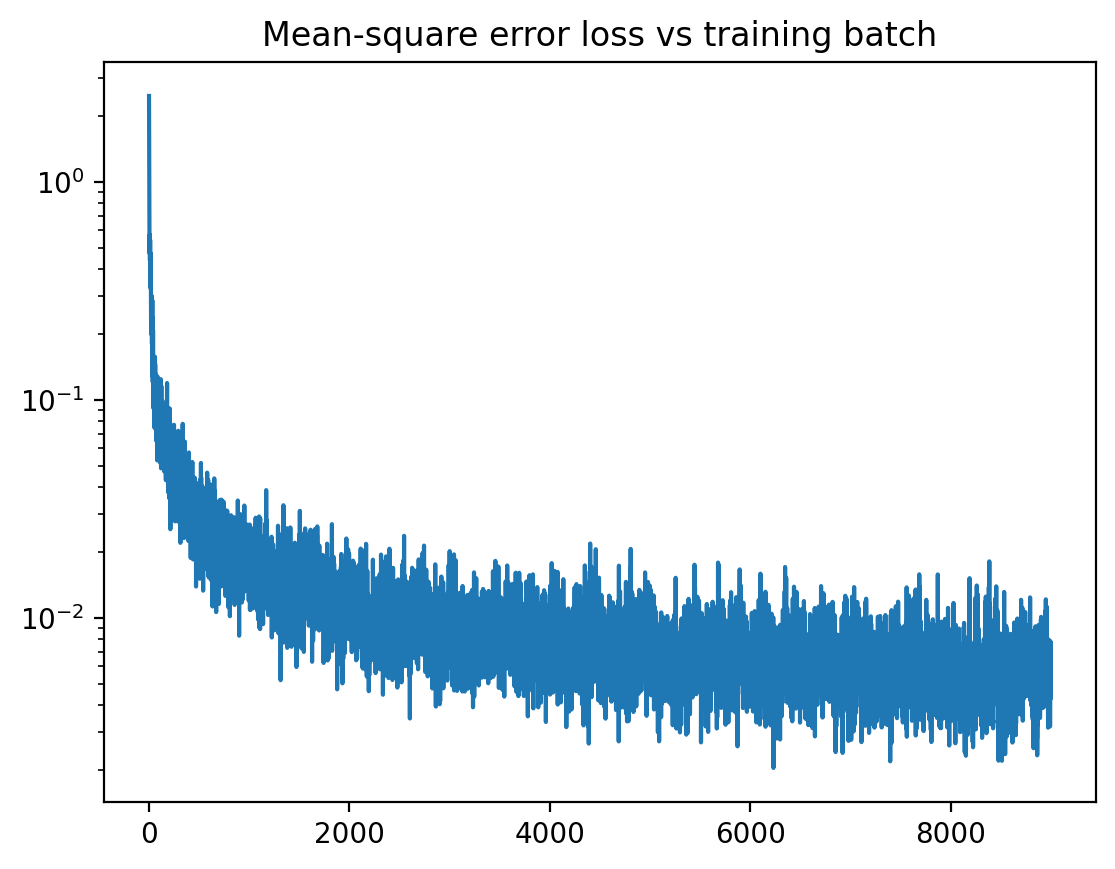

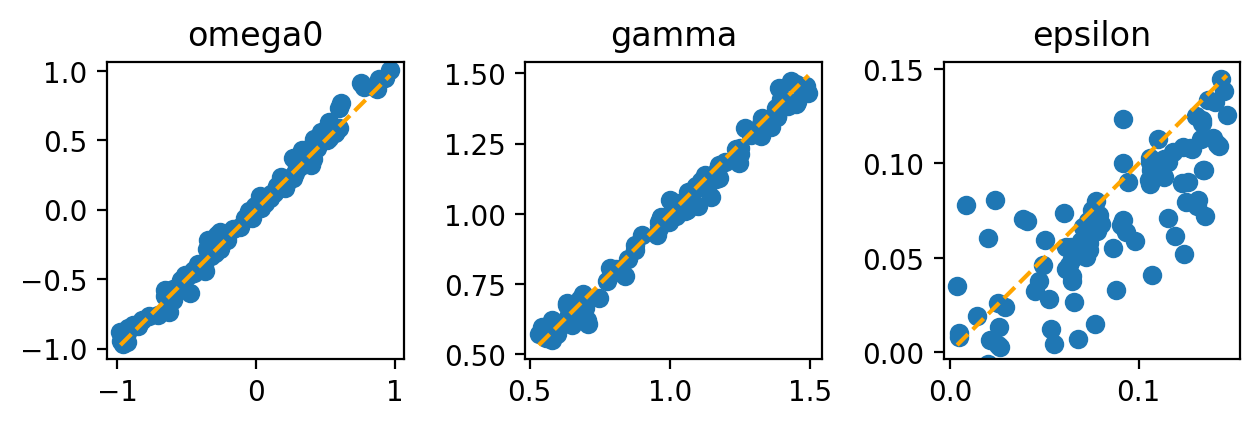

In [60]:
# run this cell multiple times to continue training!

for idx_batch in range(num_training_batches):
    # get training batch:
    subkey,key = jax.random.split( key )
    x, y_target = get_duffing_image_batch( subkey,
                                batchsize, value_ranges, npixels,
                                omega_range, low_force, high_force,
                                t_end, nsteps,
                                noise_strength)    
    
    # get loss and its gradient with respect to network parameters:
    loss, grads = mse_loss_conv_batch_val_grad( x, y_target, params )

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state)
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()

validation_batchsize = 100

subkey,key = jax.random.split( key )
x, y_target = get_duffing_image_batch( subkey,
                                validation_batchsize, value_ranges, npixels,
                                omega_range, low_force, high_force,
                                t_end, nsteps,
                                noise_strength) 
y = NN_conv_batch( x, params )


fig,ax = plt.subplots(ncols=3)
for idx, label in enumerate(["omega0","gamma","epsilon"]):
    ax[idx].scatter(y_target[:,idx],y[:,idx])
    min_max_values=[jnp.min(y_target[:,idx]),jnp.max(y_target[:,idx])]
    ax[idx].plot(min_max_values,min_max_values,"--",color="orange")
    ax[idx].set_ylim(ax[idx].get_xlim())
    ax[idx].set_title(label)
    ax[idx].set_aspect(1.0)
fig.tight_layout()

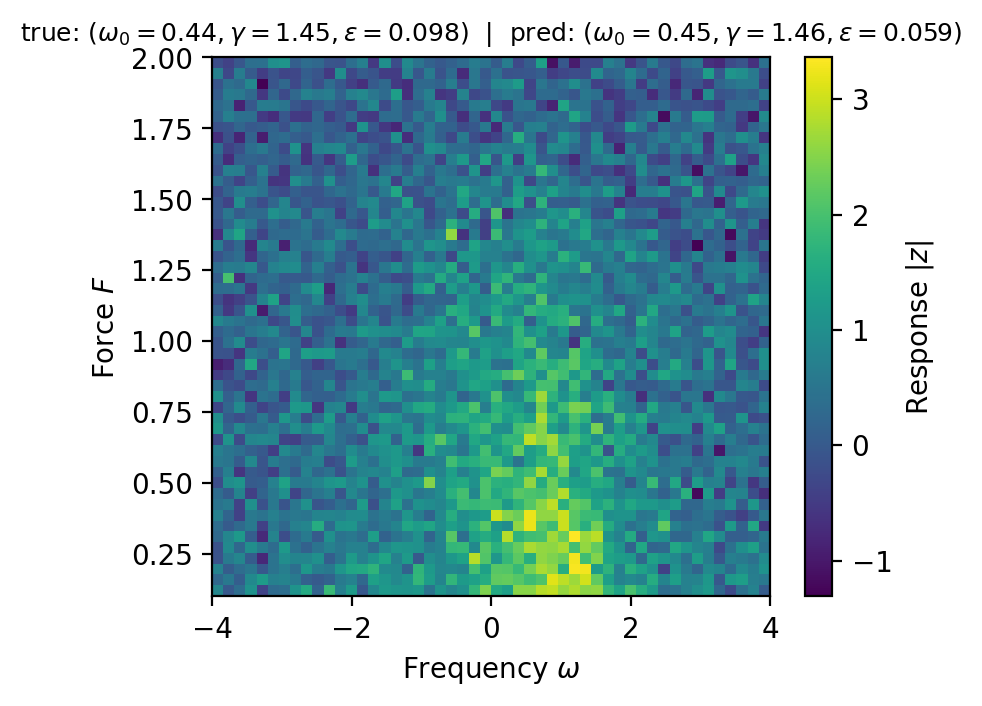

Physical parameters (omega0, gamma, epsilon):
True: [0.44040966 1.4502172  0.09827868]
NN:   [0.4466886  1.4629174  0.05880939]


In [61]:
idx=15 # sample index
is_chw = (x.ndim == 4 and x.shape[1] == 3)  # (B, C, H, W) vs (B, H, W, C)
img = np.asarray(x[idx, 0] if is_chw else x[idx, :, :, 0])  # response channel

extent = [-omega_range, +omega_range, low_force, high_force]

fig, ax = plt.subplots(figsize=(4.5, 3.5))
im = ax.imshow(img, extent=extent, origin="upper", aspect="auto", cmap="viridis")
ax.set_xlabel(r"Frequency $\omega$")
ax.set_ylabel(r"Force $F$")

# show true vs predicted parameters in the title
ω0_t, γ_t, ε_t = map(float, np.asarray(y_target[idx]))
ω0_p, γ_p, ε_p = map(float, np.asarray(y[idx]))
ax.set_title(rf"true: $(\omega_0={ω0_t:.2f}, \gamma={γ_t:.2f}, \epsilon={ε_t:.3f})$  |  "
             rf"pred: $(\omega_0={ω0_p:.2f}, \gamma={γ_p:.2f}, \epsilon={ε_p:.3f})$", fontsize=9)

fig.colorbar(im, ax=ax, label=r"Response $|z|$")
plt.show()
print("Physical parameters (omega0, gamma, epsilon):")
print(f"True: {y_target[idx]}")
print(f"NN:   {y[idx]}")